In [1]:
from datetime import datetime
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import matplotlib.pyplot as plt

#### Loading the Data

In [2]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
print(training_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [3]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

In [4]:
data_train, labels_train = next(iter(train_dataloader))
print(f"Feature batch shape: {data_train.shape}")
print(f"Labels batch shape: {labels_train.shape}")

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


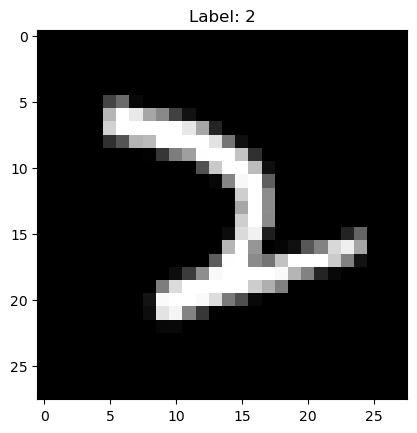

In [5]:
img = data_train[0].squeeze()
label = labels_train[0]
plt.imshow(img, cmap="gray")
plt.title(f"Label: {label}")
plt.show()

#### Multinomial Logistic Regression


##### Model

In [6]:
class LogisticRegression(torch.nn.Module):
    
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.linear  = torch.nn.Linear(28*28,10)
    
    def forward(self, x):
        z = self.linear(self.flatten(x))
        return z


In [7]:
model = LogisticRegression()
print(model)

LogisticRegression(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [8]:
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


##### Cost

In [9]:
cost_ce = torch.nn.CrossEntropyLoss()

##### Training

In [10]:
import math
def plot_training(nepochs, cost_hist, cost_hist_test, acc_hist, acc_hist_test):
    plt.figure(1)
    plt.plot(torch.arange(nepochs), cost_hist, "-")
    plt.plot(torch.arange(nepochs), cost_hist_test, "r-")
    mincost = max(max(cost_hist),1.0)
    plt.xlabel("Epoch")
    plt.xlim(0,nepochs)
    plt.ylim(0,mincost)
    plt.title("Cross-Entropy Cost")
    plt.figure(2)
    plt.plot(torch.arange(nepochs), acc_hist,"-")
    plt.plot(torch.arange(nepochs), acc_hist_test,"r-")
    minacc = min(min(acc_hist),0.8)
    plt.xlabel("Epoch")
    plt.xlim(0,nepochs)
    plt.ylim(minacc,1)
    plt.title("Accuracy")

In [11]:
nepochs = 10
learning_rate = 0.1

cost_hist = []
cost_hist_test = []
acc_hist = []
acc_hist_test = []

model = LogisticRegression()
cost_ce = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Xtrain, Ytrain = next(iter(DataLoader(training_data, batch_size=60000, shuffle=True)))
Xtest, Ytest = next(iter(DataLoader(test_data, batch_size=10000, shuffle=True)))

for epoch in range(nepochs):
    pred = model(Xtrain)
    loss = cost_ce(pred, Ytrain)
    cost = loss.item()
    acc = (pred.argmax(dim=1) == Ytrain).type(torch.float).mean().item()
    # gradient, parameter update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        pred = model(Xtest)
        cost_test = cost_ce(pred, Ytest).item()
        acc_test = (pred.argmax(dim=1) == Ytest).type(torch.float).mean().item()
    print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_test, acc_test))
    cost_hist.append(cost)
    cost_hist_test.append(cost_test)
    acc_hist.append(acc)
    acc_hist_test.append(acc_test)


Epoch 0: 2.321467, 0.083000, 2.208401, 0.247200
Epoch 1: 2.214185, 0.239517, 2.109108, 0.421500
Epoch 2: 2.116556, 0.412283, 2.017614, 0.539200
Epoch 3: 2.026606, 0.531633, 1.932951, 0.613200
Epoch 4: 1.943379, 0.605000, 1.854523, 0.656600
Epoch 5: 1.866287, 0.648733, 1.781868, 0.685000
Epoch 6: 1.794869, 0.677567, 1.714574, 0.705300
Epoch 7: 1.728714, 0.697117, 1.652248, 0.721700
Epoch 8: 1.667434, 0.712050, 1.594511, 0.733700
Epoch 9: 1.610654, 0.723817, 1.541002, 0.745900


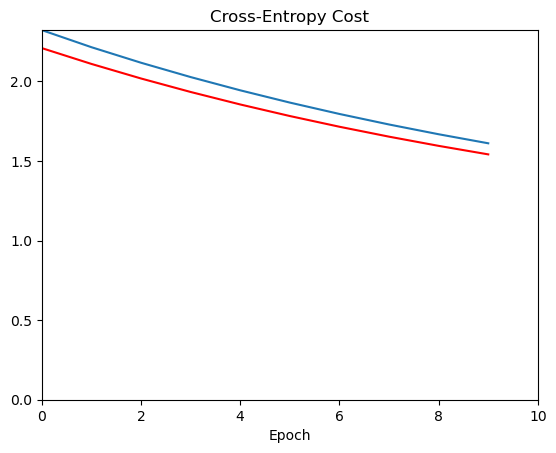

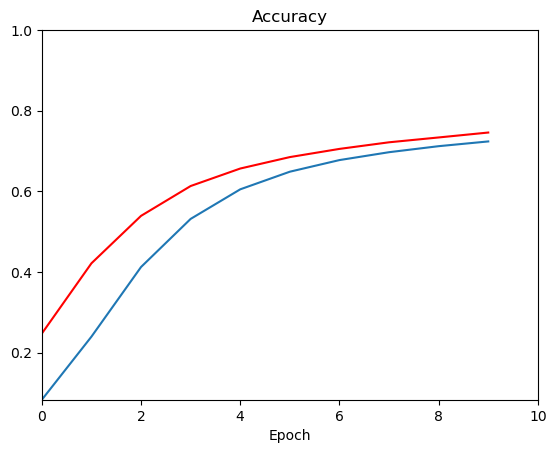

In [12]:
plot_training(nepochs, cost_hist, cost_hist_test, acc_hist, acc_hist_test)

#### Stochastic Gradient Descent

In [13]:
nbatch = 64
nepochs = 10
learning_rate = 0.01

cost_hist = []
cost_hist_test = []
acc_hist = []
acc_hist_test = []

model = LogisticRegression()
cost_ce = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10000, shuffle=True)
size = len(training_loader.dataset)
nbatches = len(training_loader)

Xtest, Ytest = next(iter(test_loader))

for epoch in range(nepochs):
    cost, acc = 0.0, 0.0
    for batch, (X, Y) in enumerate(training_loader):
        pred = model(X)
        loss = cost_ce(pred, Y)
        cost += loss.item()
        acc += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()

        # gradient, parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    cost /= nbatches
    acc /= size
    
    with torch.no_grad():
        pred = model(Xtest)
        cost_test = cost_ce(pred, Ytest).item()
        acc_test = (pred.argmax(dim=1) == Ytest).type(torch.float).mean().item()
    print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_test, acc_test))
    cost_hist.append(cost)
    cost_hist_test.append(cost_test)
    acc_hist.append(acc)
    acc_hist_test.append(acc_test)


Epoch 0: 0.980201, 0.801850, 0.603077, 0.868100
Epoch 1: 0.552036, 0.866617, 0.477936, 0.882700
Epoch 2: 0.472100, 0.878800, 0.427259, 0.891100
Epoch 3: 0.433269, 0.886250, 0.398629, 0.895400
Epoch 4: 0.409137, 0.890983, 0.379775, 0.900100
Epoch 5: 0.392368, 0.894500, 0.366300, 0.903400
Epoch 6: 0.379613, 0.897167, 0.356041, 0.905500
Epoch 7: 0.369598, 0.899067, 0.347743, 0.907000
Epoch 8: 0.361738, 0.900667, 0.340971, 0.907800
Epoch 9: 0.354725, 0.902633, 0.335868, 0.909400


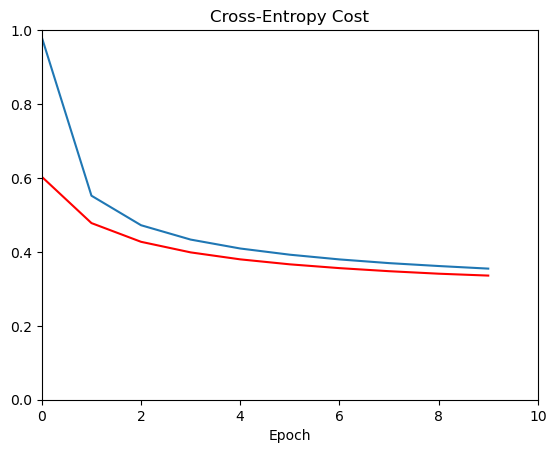

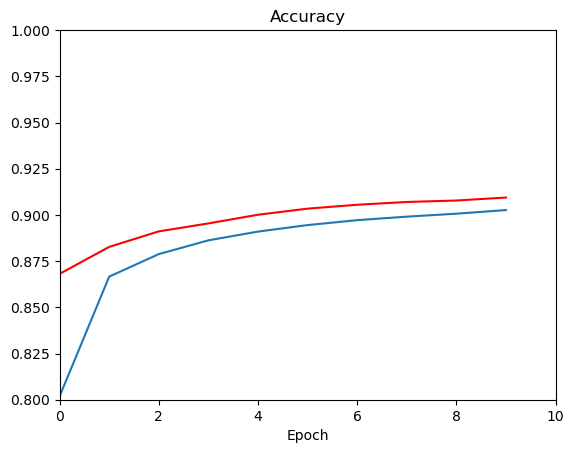

In [14]:
plot_training(nepochs, cost_hist, cost_hist_test, acc_hist, acc_hist_test)

#### MLP

In [15]:
class MLP3HiddenLayers(torch.nn.Module):
    
    def __init__(self, ninput=28*28, nhidden1 = 200, nhidden2 = 100, nhidden3= 50, noutput=10):
        super(MLP3HiddenLayers, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(ninput,nhidden1),
            torch.nn.ReLU(),
            torch.nn.Linear(nhidden1, nhidden2),
            torch.nn.ReLU(),
            torch.nn.Linear(nhidden2, nhidden3),
            torch.nn.ReLU(),
            torch.nn.Linear(nhidden3, noutput),
        ) 
    
    def forward(self, x):
        z = self.layers(x)
        return z


In [16]:
model = MLP3HiddenLayers(ninput=28*28, nhidden1=200, nhidden2=100, nhidden3=50, noutput=10)
print(model)

MLP3HiddenLayers(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=200, bias=True)
    (2): ReLU()
    (3): Linear(in_features=200, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=50, bias=True)
    (6): ReLU()
    (7): Linear(in_features=50, out_features=10, bias=True)
  )
)


In [17]:
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 200]         157,000
              ReLU-3                  [-1, 200]               0
            Linear-4                  [-1, 100]          20,100
              ReLU-5                  [-1, 100]               0
            Linear-6                   [-1, 50]           5,050
              ReLU-7                   [-1, 50]               0
            Linear-8                   [-1, 10]             510
Total params: 182,660
Trainable params: 182,660
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.70
Estimated Total Size (MB): 0.71
----------------------------------------------------------------


In [18]:
nbatch = 64
nepochs = 10
learning_rate = 0.01

cost_hist = []
cost_hist_test = []
acc_hist = []
acc_hist_test = []

model = MLP3HiddenLayers(ninput=28*28, nhidden1=200, nhidden2=100, nhidden3=50, noutput=10)
cost_ce = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10000, shuffle=True)
size = len(training_loader.dataset)
nbatches = len(training_loader)

Xtest, Ytest = next(iter(test_loader))

for epoch in range(nepochs):
    cost, acc = 0.0, 0.0
    for batch, (X, Y) in enumerate(training_loader):
        pred = model(X)
        loss = cost_ce(pred, Y)
        cost += loss.item()
        acc += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()

        # gradient, parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    cost /= nbatches
    acc /= size
    
    with torch.no_grad():
        pred = model(Xtest)
        cost_test = cost_ce(pred, Ytest).item()
        acc_test = (pred.argmax(dim=1) == Ytest).type(torch.float).mean().item()
    print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_test, acc_test))
    cost_hist.append(cost)
    cost_hist_test.append(cost_test)
    acc_hist.append(acc)
    acc_hist_test.append(acc_test)


Epoch 0: 2.224253, 0.294783, 1.955396, 0.506400
Epoch 1: 0.988621, 0.745550, 0.527827, 0.850400
Epoch 2: 0.473838, 0.863050, 0.412989, 0.877300
Epoch 3: 0.392698, 0.886400, 0.353988, 0.895500
Epoch 4: 0.344520, 0.900450, 0.326357, 0.904500
Epoch 5: 0.307353, 0.911133, 0.298276, 0.911300
Epoch 6: 0.275463, 0.920533, 0.252121, 0.925900
Epoch 7: 0.246383, 0.929633, 0.230112, 0.931600
Epoch 8: 0.221335, 0.936333, 0.209263, 0.938000
Epoch 9: 0.200245, 0.942517, 0.190910, 0.944700


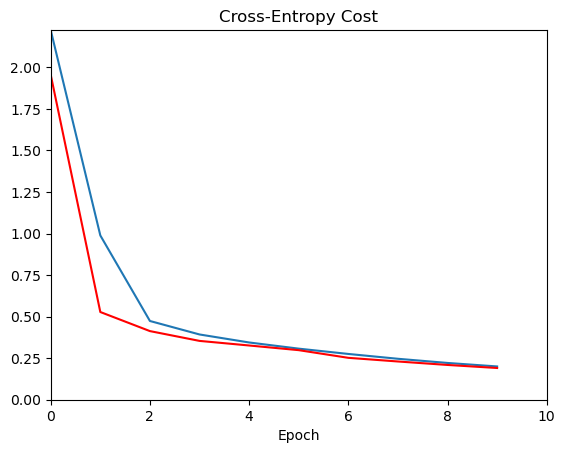

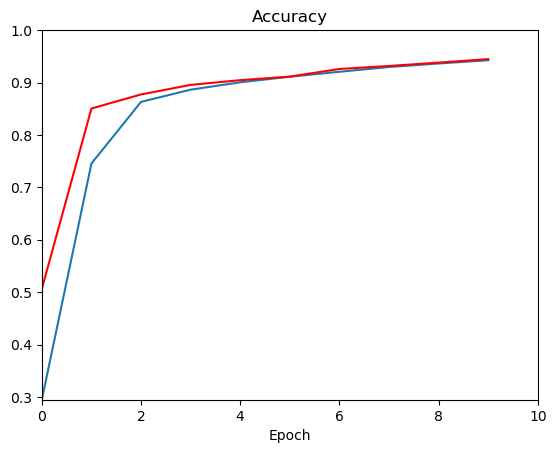

In [19]:
plot_training(nepochs, cost_hist, cost_hist_test, acc_hist, acc_hist_test)

#### Hyper-Parameter Tuning

Modify learning rate, batchsize, number of layers and units per layer and explore what changes these modification have on performance (train and test accuracy).

...